<a href="https://colab.research.google.com/github/yukliio/Autoencoder-Driven-Model-Based-Transfer/blob/main/nbs/VAE_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is an autoencoder?

In [1]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import matplotlib.pyplot as plt



In [2]:
# load the MNIST dataset

mnist_train = torchvision.datasets.MNIST(
    root='./',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

mnist_test = torchvision.datasets.MNIST(
    root='./',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 14.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.21MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.11MB/s]


In [3]:
print("Number of training samples:", len(mnist_train))

loader = DataLoader(mnist_train, batch_size=len(mnist_train))
images, ground_truth = next(iter(loader))

Number of training samples: 60000


In [4]:
images = images.squeeze()  # removes dimensions of size (1)
print(images.shape)
print(ground_truth.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [5]:
print(torch.min(images[0]))
print(torch.max(images[0]))

images_int = (images * 255).byte()  # convert to 0-255
print(images_int.min(), images_int.max())  # 0 255

tensor(0.)
tensor(1.)
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


tensor(7)


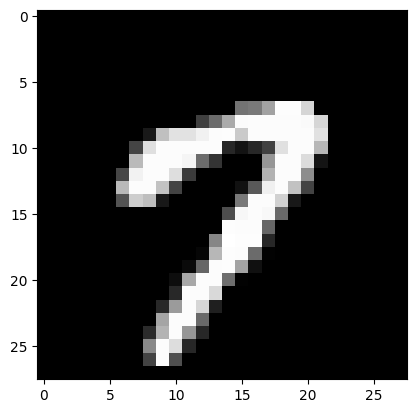

In [6]:
image_index = 15

print(ground_truth[image_index])
plt.imshow(images[image_index], cmap='gray')

In [7]:
import torch
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(
    root='./',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)


# stack all images into one tensor
all_images = torch.stack([img for img, label in mnist_train])  # [60000, 1, 28, 28]

# stack all labels into one tensor
all_labels = torch.tensor([label for img, label in mnist_train])  # [60000]

# save to file
torch.save((all_images, all_labels), 'mnist_train.pt')
print("File saved as mnist_train.pt")

File saved as mnist_train.pt


In [8]:

mnist_test = datasets.MNIST(
    root='./',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)


# stack all images into one tensor
all_images = torch.stack([img for img, label in mnist_test])

# stack all labels into one tensor
all_labels = torch.tensor([label for img, label in mnist_test])

# save to file
torch.save((all_images, all_labels), 'mnist_test.pt')
print("File saved as mnist_test.pt")

File saved as mnist_test.pt


In [9]:
# map style pytorch dataset

class MNISTDataset(Dataset):
  # need to implement getitem and len methods. creates a map dataste and can query the dataset via index
  def __init__(self, path):
    # loads data into memory
    self.images, self.ground_truth = torch.load(path)

  def __getitem__(self, idx):
    # returns the image with index idx
    x = self.images[idx].float()
    x = torch.flatten(x)
    y = self.ground_truth[idx]

    return x, y

  def __len__(self):
  # returns the length of the dataset
    return len(self.ground_truth)



In [10]:
# make the dataset
train_dataset = MNISTDataset("mnist_train.pt")
test_dataset = MNISTDataset("mnist_test.pt")

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)



In [11]:
print(len(train_dataset))
print(len(test_dataset))

60000
60000


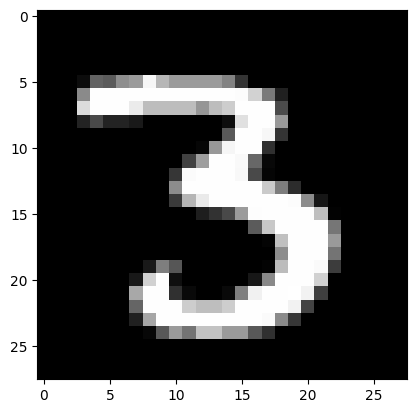

In [12]:
x, y = train_dataset[12]
plt.imshow(x.numpy().reshape(28,28), cmap='gray')

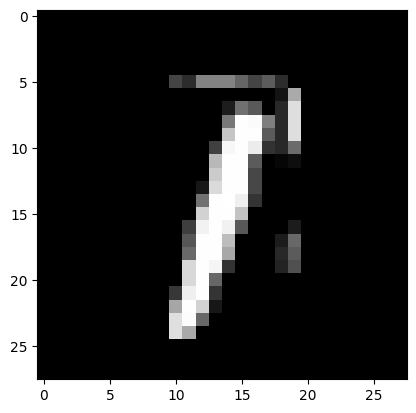

In [27]:
import torch.nn as nn
import torch.nn.functional as F

class AutoEncoder(nn.Module):
  """
  params:
    - input_shape: shape fo the input data
    - latent_dim: size of the latent dim
  """
  def __init__(self, input_shape, latent_dim=128):
    super().__init__()
    # two fully connected layers for encoder (input_shape --> latent dim)
    self.encoder_11 = nn.Linear(in_features=input_shape, out_features=latent_dim)
    self.encoder_12 = nn.Linear(in_features=latent_dim, out_features=latent_dim)

    # two fully connected layers for decder (128 --> input_shape)
    self.decoder_11 = nn.Linear(in_features=latent_dim, out_features=latent_dim)
    self.decoder_12 = nn.Linear(in_features=latent_dim, out_features=input_shape)

  def forward(self, x):
    """
    params:
      - x: input data

    returns:
      - x_hat: reconstructed data
    """

    latent = self.run_encoder(x)
    x_hat = self.run_decoder(latent)
    return x_hat

  def run_encoder(self, x):
    # runs encoder
    output = F.relu(self.encoder_11(x))
    latent = F.relu(self.encoder_12(output))
    return latent

  def run_decoder(self, latent):
    # runs decoder
    output = F.relu(self.decoder_11(latent))
    x_hat = F.relu(self.decoder_12(output))
    return x_hat


In [30]:
x, y = train_dataset[0]
image_shape = x.shape[0]
print(image_shape)
model = AutoEncoder(input_shape=image_shape)
model.train()
model.cuda()


784


AutoEncoder(
  (encoder_11): Linear(in_features=784, out_features=128, bias=True)
  (encoder_12): Linear(in_features=128, out_features=128, bias=True)
  (decoder_11): Linear(in_features=128, out_features=128, bias=True)
  (decoder_12): Linear(in_features=128, out_features=784, bias=True)
)

In [31]:
import torch.nn as nn
import torch.optim as optim

mae = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 100

for epoch in range(n_epochs):
    loss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.cuda()

        # reset gradients back to zero
        optimizer.zero_grad()


        outputs = model(batch_features)
        train_loss = mae(outputs, batch_features)
        train_loss.backward()
        optimizer.step()

        loss += train_loss.item()

    loss = loss / len(train_loader)

    if epoch % 5 == 0:
        print("epoch: {}/{}, loss = {:.6f}".format(epoch + 1, n_epochs, loss))

# final report
print("epoch: {}/{}, loss = {:.6f}".format(n_epochs, n_epochs, loss))



epoch: 1/100, loss = 0.027503
epoch: 6/100, loss = 0.014296
epoch: 11/100, loss = 0.013373
epoch: 16/100, loss = 0.012996
epoch: 21/100, loss = 0.012755
epoch: 26/100, loss = 0.012611
epoch: 31/100, loss = 0.012491
epoch: 36/100, loss = 0.012433
epoch: 41/100, loss = 0.012368
epoch: 46/100, loss = 0.012334
epoch: 51/100, loss = 0.012309
epoch: 56/100, loss = 0.012300
epoch: 61/100, loss = 0.012291
epoch: 66/100, loss = 0.012281
epoch: 71/100, loss = 0.012271
epoch: 76/100, loss = 0.012265
epoch: 81/100, loss = 0.012264
epoch: 86/100, loss = 0.012251
epoch: 91/100, loss = 0.012252
epoch: 96/100, loss = 0.012254
epoch: 100/100, loss = 0.012238


In [ ]:
model.eval()